# Tanzania's Water Wells
\
\
![Blue logo of a Water Droplet made out of hands with Africa in the middle with the words The Water Project](images/TheWaterProject.png)

## Overview

The Water Project is a non-profit organization which helps to reduce water scarcity in sub-Saharan Africa by providing the necessary resources for water well construction. Our team is helping The Water Project by using machine learning models to predict the functionality of wells throughout Tanzania. More specifically, we aim to identify wells that are in working condition but are in need of repair to guide The Water Project's future work in this region. This allows them to maximize water access while allocating resources in the most efficient way.

## Data Understanding

The source of our data was [Taarifa](http://taarifa.org/) organization and the [Tanzanian Ministry of Water](http://maji.go.tz/). The dataset contained over 59000 rows of 40 feature columns describing waterpoints in the region installed between the years 1960 and 2013. It was hosted at [drivendata.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) as a data analysis competition. If you want descriptions of each feature, you can find them [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/25/).

In [45]:
# The libraries we need for this project

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report, recall_score
from imblearn.over_sampling import SMOTENC

In [14]:
# importing feature data, characteristics of the waterpoints
training_vals = pd.read_csv('./data/training_vals.csv')
# importing target data, the functionality of the wells
training_labels = pd.read_csv('./data/training_labels.csv')
data = pd.merge(training_vals, training_labels)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Data Preparation

Once the data was imported, we analyzed it for nulls and missing values, as well as inspected each column for relevancy to our project.

In [6]:
# exploring nulls in each column
data.isna().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [13]:
# exploring unique values for each column
for col in data.columns:
    print(data[col].value_counts())

2047     1
72310    1
49805    1
51852    1
62091    1
        ..
46396    1
36155    1
34106    1
38200    1
0        1
Name: id, Length: 59400, dtype: int64
0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64
2011-03-15    572
2011-03-17    558
2013-02-03    546
2011-03-14    520
2011-03-16    513
             ... 
2011-09-01      1
2004-01-07      1
2011-09-06      1
2011-09-23      1
2011-09-14      1
Name: date_recorded, Length: 356, dtype: int64
Government Of Tanzania      9084
Danida                      3114
Hesawa                      2202
Rwssp                       1374
World Bank                  1349
                            ... 
Eung-am Methodist Church       1
Kidika                         1
Halimashau                     1
Rilayo Water Project           1
Masese                   

Name: quantity_group, dtype: int64
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64
commu

In [24]:
# making a list of all the columns that are redundant or not useful for our model
drop_cols_list = ['id','date_recorded', 'latitude', 'longitude', 'wpt_name', 'num_private', 'region_code',
                 'district_code', 'lga', 'ward', 'subvillage', 'public_meeting', 'recorded_by', 'extraction_type',
                  'extraction_type_group', 'management_group', 'payment_type', 'water_quality', 'quantity_group',
                  'source_type', 'source_class', 'waterpoint_type']

# creating dataframe without columns mentioned above
df = data.drop(drop_cols_list, axis=1)

# checking new dataframe
df.head()

,amount_tsh,funder,gps_height,installer,basin,region,population,scheme_management,scheme_name,permit,construction_year,extraction_type_class,management,payment,quality_group,quantity,source,waterpoint_type_group,status_group
0,6000.0,Roman,1390,Roman,Lake Nyasa,Iringa,109,VWC,Roman,False,1999,gravity,vwc,pay annually,good,enough,spring,communal standpipe,functional
1,0.0,Grumeti,1399,GRUMETI,Lake Victoria,Mara,280,Other,NaN,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,functional
2,25.0,Lottery Club,686,World vision,Pangani,Manyara,250,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,vwc,pay per bucket,good,enough,dam,communal standpipe,functional
3,0.0,Unicef,263,UNICEF,Ruvuma / Southern Coast,Mtwara,58,VWC,NaN,True,1986,submersible,vwc,never pay,good,dry,machine dbh,communal standpipe,non functional
4,0.0,Action In A,0,Artisan,Lake Victoria,Kagera,0,NaN,NaN,True,0,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,functional


In [25]:
# checking shape of new dataframe
df.shape

(59400, 19)

In [26]:
# dropping nulls
df = df.dropna()

# checking shape of dataframe
df.shape

(28986, 19)

In [28]:
# removing all rows with '0' in 'construction_year' column
df = df.drop(df.loc[df['construction_year']==0].index)

# checking shape of dataframe
df.shape

(22710, 19)

In [29]:
# checking class imbalance of the target
df['status_group'].value_counts()

functional                 13737
non functional              7295
functional needs repair     1678
Name: status_group, dtype: int64

## Model Selection

### Train Test Split

We split our data in training and test sets

In [31]:
X = df.drop('status_group', axis=1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y)

### Creating Column Transformer for Numerical and Categorical Data

In [35]:
# creating function to grab numerical and categorical columns
def grab_numeric(df):
    df = pd.DataFrame(df)
    return df.select_dtypes(include=['float', 'int'])

def grab_categorical(df):
    df = pd.DataFrame(df)
    return df.select_dtypes(include=['object'])

In [36]:
# creating function transformers
GrabNum = FunctionTransformer(grab_numeric)
GrabCat = FunctionTransformer(grab_categorical)

In [37]:
# creating subpipelines, including scaling for numerical data and one hot encoding for categorical data
subpipe_num = Pipeline(steps=[('grab_num', GrabNum), ('scaler', StandardScaler())])
subpipe_cat = Pipeline(steps=[('grab_cat', GrabCat), ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

In [38]:
# creating column transformer
col_trans = ColumnTransformer(transformers=[('subpipe_num', subpipe_num, X.columns),
                                            ('subpipe_cat', subpipe_cat, X.columns)])

### Synthesizing Data for Oversampling Imbalanced Target Class

In [39]:
# making list of categorical variables
smote_cat_cols = list(grab_categorical(X_train).columns)

# checking categorical columns
smote_cat_cols

['funder',
 'installer',
 'basin',
 'region',
 'scheme_management',
 'scheme_name',
 'permit',
 'extraction_type_class',
 'management',
 'payment',
 'quality_group',
 'quantity',
 'source',
 'waterpoint_type_group']

In [41]:
# gets index nuber for columns to use to instantiatin SMOTENC
smote_cat_index = [X_train.columns.get_loc(c) for c in smote_cat_cols]

# checking index of categorical columns
smote_cat_index

[1, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17]

In [42]:
# instantiating SMOTENC
smtnc = SMOTENC(smote_cat_index, sampling_strategy='auto')

In [44]:
# creating synthetic data
X_train_smote_rs, y_train_smote_rs = smtnc.fit_resample(X_train, y_train)

# checking target value counts
y_train_smote_rs.value_counts()

functional needs repair    10291
non functional             10291
functional                 10291
Name: status_group, dtype: int64

### Creating Baseline Model

In [46]:
# instantiating dummy classifier and fitting to training data
dummy_clf = DummyClassifier(strategy='constant', constant='functional needs repair')
dummy_clf.fit(X_train, y_train)

# getting accuracy score
dummy_clf.score(X_train, y_train)

0.07374354156881165

In [47]:
# gettting recall_score
y_pred_baseline = dummy_clf.predict(X_train)
recall = recall_score(y_train, y_pred_baseline, average='weighted')
recall

0.07374354156881165

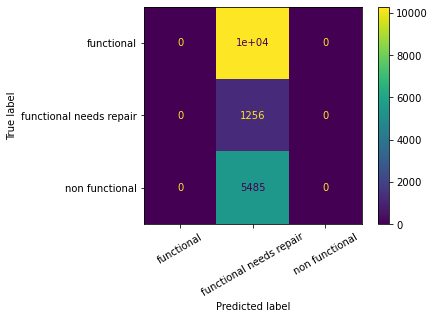

In [52]:
# creating confusion matrix for baseline model
conf_matrix = plot_confusion_matrix(dummy_clf, X_train, y_train)
plt.xticks(rotation=30);

### Grid Searching Different Model Types for Hyperparameter Tuning

#### K-Nearest Neighbors

In [53]:
# creating pipeline for k-nearest neighbors
knn_pipe = Pipeline(steps=[('col_trans', col_trans), ('knn', KNeighborsClassifier())])

# fitting pipeline to training data
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('grab_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x7f8a46742dc0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'ex...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['amount_tsh', 'funder', 'gps_heig

In [ ]:
# first grid search
knn_params1 = {}
knn_params1['knn__n_neighbors'] = [3, 5, 7, 11]
knn_params1['knn__weights'] = ['uniform', 'distance']
knn_params1['knn__p'] = [1, 2]

knn_grid1 = GridSearchCV(knn_pipe, param_grid=knn_params1, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

knn_grid1.fit(X_train, y_train)

In [ ]:
# best parameters from search
knn_grid1.best_params_

In [ ]:
# best recall score from search
knn_grid1.best_score_

In [ ]:
classification_report(y_test, knn_grid1.best_estimator_.predict(X_test), output_dict=True)

Best parameters for first grid search:\
{'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'}

Best score for first grid search:\
0.7852865180124783

Classification report for first grid search:\
{'functional': {'precision': 0.8244505494505494,\
  'recall': 0.8739079790331974,\
  'f1-score': 0.8484591461690698,\
  'support': 3434},\
 'functional needs repair': {'precision': 0.41114982578397213,\
  'recall': 0.28433734939759037,\
  'f1-score': 0.33618233618233617,\
  'support': 415},\
 'non functional': {'precision': 0.7824100513992005,\
  'recall': 0.7490431930016402,\
  'f1-score': 0.76536312849162,\
  'support': 1829},\
 'accuracy': 0.7905952800281789,\
 'macro avg': {'precision': 0.6726701422112407,\
  'recall': 0.6357628404774761,\
  'f1-score': 0.6500015369476754,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7807006601836338,\
  'recall': 0.7905952800281789,\
  'f1-score': 0.7842503591883458,\
  'support': 5678}}

In [ ]:
# second grid search
knn_params2 = {}
knn_params2['knn__n_neighbors'] = [11, 15, 20]
knn_params2['knn__weights'] = ['uniform', 'distance']
knn_params2['knn__p'] = [1, 2]

knn_grid2 = GridSearchCV(knn_pipe, param_grid=knn_params2, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

knn_grid2.fit(X_train, y_train)

In [ ]:
# best parameters from search
knn_grid2.best_params_

In [ ]:
# best recall score from search
knn_grid2.best_score_

In [ ]:
classification_report(y_test, knn_grid2.best_estimator_.predict(X_test), output_dict=True)

Best parameters for second grid search:\
{'knn__n_neighbors': 20, 'knn__p': 1, 'knn__weights': 'distance'}

Best score for second grid search:\
0.7856975849252702

Classification report for second grid search:\
{'functional': {'precision': 0.8203592814371258,\
  'recall': 0.877693651718113,\
  'f1-score': 0.8480585256049521,\
  'support': 3434},\
 'functional needs repair': {'precision': 0.4122137404580153,\
  'recall': 0.26024096385542167,\
  'f1-score': 0.31905465288035445,\
  'support': 415},\
 'non functional': {'precision': 0.7807118254879449,\
  'recall': 0.7435757244395844,\
  'f1-score': 0.7616914029683561,\
  'support': 1829},\
 'accuracy': 0.7893624515674533,\
 'macro avg': {'precision': 0.6710949491276953,\
  'recall': 0.6271701133377063,\
  'f1-score': 0.6429348604845543,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7777570277496686,\
  'recall': 0.7893624515674533,\
  'f1-score': 0.7815734825470018,\
  'support': 5678}}

In [ ]:
# Third grid search
knn_params3 = {}
knn_params3['knn__n_neighbors'] = [20, 25, 30]
knn_params3['knn__weights'] = ['uniform', 'distance']
knn_params3['knn__p'] = [1, 2]

knn_grid3 = GridSearchCV(knn_pipe, param_grid=knn_params3, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

knn_grid3.fit(X_train, y_train)

In [ ]:
# best parameters from search
knn_grid3.best_params_

In [ ]:
# best recall score from search
knn_grid3.best_score_

In [ ]:
classification_report(y_test, knn_grid3.best_estimator_.predict(X_test), output_dict=True)

Best parameters for third grid search:\
{'knn__n_neighbors': 20, 'knn__p': 1, 'knn__weights': 'distance'}

Best score for third grid search:\
0.7856975849252702

Classification report for third grid search:\
{'functional': {'precision': 0.8203592814371258,\
  'recall': 0.877693651718113,\
  'f1-score': 0.8480585256049521,\
  'support': 3434},\
 'functional needs repair': {'precision': 0.4122137404580153,\
  'recall': 0.26024096385542167,\
  'f1-score': 0.31905465288035445,\
  'support': 415},\
 'non functional': {'precision': 0.7807118254879449,\
  'recall': 0.7435757244395844,\
  'f1-score': 0.7616914029683561,\
  'support': 1829},\
 'accuracy': 0.7893624515674533,\
 'macro avg': {'precision': 0.6710949491276953,\
  'recall': 0.6271701133377063,\
  'f1-score': 0.6429348604845543,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7777570277496686,\
  'recall': 0.7893624515674533,\
  'f1-score': 0.7815734825470018,\
  'support': 5678}}

In [ ]:
# fourth grid search now with SMOTE data
knn_params4 = {}
knn_params4['knn__n_neighbors'] = [3, 5, 7, 11]
knn_params4['knn__weights'] = ['uniform', 'distance']
knn_params4['knn__p'] = [1, 2]

knn_grid4 = GridSearchCV(knn_pipe, param_grid=knn_params4, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

knn_grid4.fit(X_train_smote_rs, y_train_smote_rs)

In [ ]:
# best parameters from search
knn_grid4.best_params_

In [ ]:
# best recall score from search
knn_grid4.best_score_

In [ ]:
classification_report(y_test, knn_grid4.best_estimator_.predict(X_test), output_dict=True)

Best parameters for fourth grid search:\
{'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}

Best score for fourth grid search:\
0.8403701187356433

Classification report for fourth grid search:\
{'functional': {'precision': 0.8461061123177164,\
  'recall': 0.7941176470588235,\
  'f1-score': 0.8192879675529517,\
  'support': 3434},\
 'functional needs repair': {'precision': 0.3139717425431711,\
  'recall': 0.4819277108433735,\
  'f1-score': 0.38022813688212925,\
  'support': 415},\
 'non functional': {'precision': 0.759075907590759,\
  'recall': 0.7545106615636961,\
  'f1-score': 0.7567863997806415,\
  'support': 1829},\
 'accuracy': 0.7585417400493132,\
 'macro avg': {'precision': 0.6397179208172155,\
  'recall': 0.6768520064886311,\
  'f1-score': 0.6521008347385742,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7791786716868532,\
  'recall': 0.7585417400493132,\
  'f1-score': 0.7670644386371458,\
  'support': 5678}}


#### Random Forest Classifier

In [54]:
# creating pipeline for random forest
forest_pipe = Pipeline(steps=[('col_trans', col_trans), ('forest', RandomForestClassifier())])

# fitting pipeline for random forest classifier
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('grab_num',
                                                                   FunctionTransformer(func=<function grab_numeric at 0x7f8a46742dc0>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'basin', 'region',
       'population', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'ex...
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  Index(['amount_tsh', 'funder', 'gps_heig

In [ ]:
# first grid search
rfc_params1 = {}
rfc_params1['forest__n_estimators'] = [1000, 2000]
rfc_params1['forest__max_depth'] = [10, 50, 100]
rfc_params1['forest__min_samples_split'] = [200, 20, 2]
rfc_params1['forest__max_features'] = ['sqrt', 'log2']
rfc_params1['forest__class_weight'] = ['balanced']

rfc_grid1 = GridSearchCV(forest_pipe, param_grid=rfc_params1, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

rfc_grid1.fit(X_train, y_train)

In [ ]:
# best parameters from search
rfc_grid1.best_params_

In [ ]:
# best recall score from search
rfc_grid1.best_score_

In [ ]:
classification_report(y_test, rfc_grid1.best_estimator_.predict(X_test), output_dict=True)

Best parameters for first grid search:\
{'forest__class_weight': 'balanced',\
 'forest__max_depth': 50,\
 'forest__max_features': 'sqrt',\
 'forest__min_samples_split': 2,\
 'forest__n_estimators': 1000}

Best score for first grid search:\
0.795796350392605

Classification report for first grid search:\
{'functional': {'precision': 0.8391158365976497,\
  'recall': 0.865262550490479,\
  'f1-score': 0.8519886363636364,\
  'support': 3466},\
 'functional needs repair': {'precision': 0.39325842696629215,\
  'recall': 0.3211009174311927,\
  'f1-score': 0.3535353535353536,\
  'support': 436},\
 'non functional': {'precision': 0.7831807780320366,\
  'recall': 0.7708333333333334,\
  'f1-score': 0.7769580022701476,\
  'support': 1776},\
 'accuracy': 0.7939415287072913,\
 'macro avg': {'precision': 0.6718516805319927,\
  'recall': 0.6523989337516684,\
  'f1-score': 0.6608273307230458,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7873838016184667,\
  'recall': 0.7939415287072913,\
  'f1-score': 0.790245058085516,\
  'support': 5678}}

In [ ]:
# second grid search
rfc_params2 = {}
rfc_params2['forest__n_estimators'] = [100, 500, 1000]
rfc_params2['forest__max_depth'] = [10, 25, 50]
rfc_params2['forest__min_samples_split'] = [2, 10, 20]
rfc_params2['forest__max_features'] = ['sqrt', 'log2']
rfc_params2['forest__class_weight'] = ['balanced']

rfc_grid2 = GridSearchCV(forest_pipe, param_grid=rfc_params2, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

rfc_grid2.fit(X_train, y_train)

In [ ]:
# best parameters from search
rfc_grid2.best_params_

In [ ]:
# best recall score from search
rfc_grid2.best_score_

In [ ]:
classification_report(y_test, rfc_grid2.best_estimator_.predict(X_test), output_dict=True)

Best parameters for second grid search:\
{'forest__class_weight': 'balanced',
 'forest__max_depth': 50,
 'forest__max_features': 'sqrt',
 'forest__min_samples_split': 2,
 'forest__n_estimators': 500}

Best score for second grid search:\
0.7969707105802074 

Classification report for second grid search:\
{'functional': {'precision': 0.8364603752450294,\
  'recall': 0.861800346220427,\
  'f1-score': 0.8489413102174221,\
  'support': 3466},\
 'functional needs repair': {'precision': 0.38268156424581007,\
  'recall': 0.31422018348623854,\
  'f1-score': 0.34508816120906805,\
  'support': 436},\
 'non functional': {'precision': 0.7821612349914236,\
  'recall': 0.7702702702702703,\
  'f1-score': 0.7761702127659575,\
  'support': 1776},\
 'accuracy': 0.7911236350827756,\
 'macro avg': {'precision': 0.6671010581607543,\
  'recall': 0.6487635999923119,\
  'f1-score': 0.6567332280641492,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7846317675158883,\
  'recall': 0.7911236350827756,\
  'f1-score': 0.7874898410308347,\
  'support': 5678}}

In [ ]:
# third grid search with SMOTE data
rfc_params3 = {}
rfc_params3['forest__n_estimators'] = [10, 100, 500]
rfc_params3['forest__max_depth'] = [10, 50, 100]
rfc_params3['forest__min_samples_split'] = [2, 50, 100]
rfc_params3['forest__max_features'] = ['sqrt', 'log2']

rfc_grid3 = GridSearchCV(forest_pipe, param_grid=rfc_params3, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

rfc_grid3.fit(X_train_smote_rs, y_train_smote_rs)

In [ ]:
# best parameters from search
rfc_grid3.best_params_

In [ ]:
# best recall score from search
rfc_grid3.best_score_

In [ ]:
classification_report(y_test, rfc_grid3.best_estimator_.predict(X_test), output_dict=True)

Best parameters for third grid search:\
{'forest__max_depth': 50,\
 'forest__max_features': 'log2',\
 'forest__min_samples_split': 2,\
 'forest__n_estimators': 500}

Best score for third grid search:\
0.855557712215321

Classification report for third grid search:\
{'functional': {'precision': 0.8484662576687116,\
  'recall': 0.8057092921642878,\
  'f1-score': 0.8265351860152397,\
  'support': 3433},\
 'functional needs repair': {'precision': 0.3380726698262243,\
  'recall': 0.4798206278026906,\
  'f1-score': 0.39666357738646896,\
  'support': 446},\
 'non functional': {'precision': 0.7787114845938375,\
  'recall': 0.7726514730405781,\
  'f1-score': 0.7756696428571429,\
  'support': 1799},\
 'accuracy': 0.7696371961958436,\
 'macro avg': {'precision': 0.6550834706962578,\
  'recall': 0.6860604643358522,\
  'f1-score': 0.6662894687529505,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7862745745162902,\
  'recall': 0.7696371961958436,\
  'f1-score': 0.7766532118007543,\
  'support': 5678}}

In [ ]:
# fourth grid search with SMOTE data
rfc_params4 = {}
rfc_params4['forest__n_estimators'] = [100, 500, 750]
rfc_params4['forest__max_depth'] = [30, 50, 70]
rfc_params4['forest__min_samples_split'] = [2, 10]
rfc_params4['forest__max_features'] = ['sqrt', 'log2']
rfc_params4['forest__class_weight'] = ['balanced', {'functional':1, 'functional needs repair':3, 'non functional': 2}]

rfc_grid4 = GridSearchCV(forest_pipe, param_grid=rfc_params4, scoring='recall_weighted', cv=3, n_jobs=-3, verbose=3)

rfc_grid4.fit(X_train_smote_rs, y_train_smote_rs)

In [ ]:
# best parameters from search
rfc_grid4.best_params_

In [ ]:
# best recall score from search
rfc_grid4.best_score_

In [ ]:
classification_report(y_test, rfc_grid4.best_estimator_.predict(X_test), output_dict=True)

Best parameters for fourth grid search:\
{'forest__class_weight': 'balanced',\
 'forest__max_depth': 50,\
 'forest__max_features': 'sqrt',\
 'forest__min_samples_split': 10,\
 'forest__n_estimators': 750}

Best score for first fourth search:\
0.859180900621118

Classification report for fourth grid search:\
{'functional': {'precision': 0.8500608272506083,\
  'recall': 0.8141567142441014,\
  'f1-score': 0.8317214700193424,\
  'support': 3433},\
 'functional needs repair': {'precision': 0.3305921052631579,\
  'recall': 0.45067264573991034,\
  'f1-score': 0.38140417457305503,\
  'support': 446},\
 'non functional': {'precision': 0.7850729517396184,\
  'recall': 0.7776542523624236,\
  'f1-score': 0.7813459927394582,\
  'support': 1799},\
 'accuracy': 0.7740401549841494,\
 'macro avg': {'precision': 0.6552419614177949,\
  'recall': 0.680827870782145,\
  'f1-score': 0.6648238791106186,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7886666324547871,\
  'recall': 0.7740401549841494,\
  'f1-score': 0.7803887829119883,\
  'support': 5678}}

#### Logistic Regression Classifier

In [ ]:
# creating pipeline for logistic regression
logreg_pipe = Pipeline(steps=[('col_trans', col_trans), ('logreg', LogisticRegression(max_iter=10000))])

# fitting pipeline for logistic regression
logreg_pipe.fit(X_train, y_train)

In [ ]:
# first grid search for logistic regression 
lr_params1 = {}
lr_params1['logreg__penalty'] = ['l1', 'l2']
lr_params1['logreg__C'] = [1.0, .10, .01, .001]
lr_params1['logreg__solver'] = ['saga', 'lbfgs']

lr_grid1 = GridSearchCV(logreg_pipe, param_grid=lr_params1, cv=3, n_jobs=-3, verbose=3)

lr_grid1.fit(X_train, y_train)

In [ ]:
# best parameters from search
lr_grid1.best_params_

In [ ]:
# best recall score from search
lr_grid1.best_score_

In [ ]:
classification_report(y_test, lr_grid1.best_estimator_.predict(X_test), output_dict=True)

Best parameters for first grid search:\
{'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

Best score for first grid search:\
0.77888636201987

Classification Report for first grid search:\
{'functional': {'precision': 0.7946179233307946,\
  'recall': 0.9085631349782293,\
  'f1-score': 0.8477789815817984,\
  'support': 3445},\
 'functional needs repair': {'precision': 0.4900662251655629,\
  'recall': 0.20441988950276244,\
  'f1-score': 0.2884990253411306,\
  'support': 362},\
 'non functional': {'precision': 0.7984886649874056,\
  'recall': 0.677712453233565,\
  'f1-score': 0.7331598727956057,\
  'support': 1871},\
 'accuracy': 0.787601268052131,\
 'macro avg': {'precision': 0.694390937827921,\
  'recall': 0.596898492571519,\
  'f1-score': 0.6231459599061783,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7764767544163361,\
  'recall': 0.787601268052131,\
  'f1-score': 0.7743531808248262,\
  'support': 5678}}

In [ ]:
# second grid search for logistic regression 
lr_params2 = {}
lr_params2['logreg__penalty'] = ['l1', 'l2']
lr_params2['logreg__C'] = [1, 10]
lr_params2['logreg__solver'] = ['saga']
lr_params2['logreg__class_weight'] = ['balanced']

lr_grid2 = GridSearchCV(logreg_pipe, param_grid=lr_params2, cv=3, n_jobs=-3, verbose=3)

lr_grid2.fit(X_train, y_train)

In [ ]:
# best parameters from search
lr_grid2.best_params_

In [ ]:
# best recall score from search
lr_grid2.best_score_

In [ ]:
classification_report(y_test, lr_grid2.best_estimator_.predict(X_test), output_dict=True)

Best parameters for second grid search:\
{'logreg__C': 10,  'logreg__class_weight': 'balanced',  'logreg__penalty': 'l1',  'logreg__solver': 'saga'}

Best Score for second grid search:\
0.6814809180093843

Classification report for second grid search:\
{'functional': {'precision': 0.886236478925774,\
  'recall': 0.6880973066898349,\
  'f1-score': 0.7746984023475709,\
  'support': 3453},\
 'functional needs repair': {'precision': 0.25037481259370314,\
  'recall': 0.7914691943127962,\
  'f1-score': 0.38041002277904323,\
  'support': 422},\
 'non functional': {'precision': 0.7594708358388454,\
  'recall': 0.7004991680532446,\
  'f1-score': 0.7287939988459319,\
  'support': 1803},\
 'accuracy': 0.6997182106375485,\
 'macro avg': {'precision': 0.6320273757861075,\
  'recall': 0.7266885563519585,\
  'f1-score': 0.6279674746575153,\
  'support': 5678},\
 'weighted avg': {'precision': 0.7987246653157236,\
  'recall': 0.6997182106375485,\
  'f1-score': 0.7308175753501468,\
  'support': 5678}}

In [ ]:
# third grid search for logistic regression with SMOTE data
lr_params3 = {}
lr_params3['logreg__penalty'] = ['l1', 'l2']
lr_params3['logreg__C'] = [10, 1.0, .10] 
lr_params3['logreg__solver'] = ['saga', 'lbfgs'] 

lr_grid3 = GridSearchCV(logreg_pipe, param_grid=lr_params3, scoring='recall_weighted', cv=3, n_jobs=-2, verbose=3)

lr_grid3.fit(X_train_smote_rs, y_train_smote_rs)

In [ ]:
# best parameters from search
lr_grid3.best_params_

In [ ]:
# best recall score from search
lr_grid3.best_score_

In [ ]:
classification_report(y_test, lr_grid3.best_estimator_.predict(X_test), output_dict=True)

Best parameters for third grid search:\
 {'logreg__C': 10, 'logreg__penalty': 'l1', 'logreg__solver': 'saga'})
 
Best score for third grid search:\
0.7500811108948153


Classification report:\
{'functional': {'precision': 0.8702372393961179,\
  'recall': 0.7011294526498697,\
  'f1-score': 0.7765838011226944,\
  'support': 3453},\
 'functional needs repair': {'precision': 0.24289195775792038,\
  'recall': 0.7085308056872038,\
  'f1-score': 0.3617664851784634,\
  'support': 422},\
 'non functional': {'precision': 0.7549549549549549,\
  'recall': 0.697171381031614,\
  'f1-score': 0.7249134948096886,\
  'support': 1803},\
 'accuracy': 0.7004226840436774,\
 'macro avg': {'precision': 0.6226947173696643,\
  'recall': 0.7022772131228958,\
  'f1-score': 0.6210879270369488,\
  'support': 5678},\
 'weighted avg': {'precision': 0.787004821696446,\
  'recall': 0.7004226840436774,\
  'f1-score': 0.7293463108777464,\
  'support': 5678}}

## Results

We found the model that returned the highest recall score for the "functional needs repair" class of water pumps was the best model from our second logistic regression grid search.
The optimal hyperparameters for this model were shown to be.

Final model parameters:\
C: 10\
class_weight: balanced\
penalty: l1\
solver: saga

Baseline model "functional needs repair" class recall score: 0.07374354156881165\
Final model "functional needs repair" class recall score: 0.7914691943127962

Below is a graph of the results of our model showing the true positive predictions and the false negative predictions for each class. 
[stacked bar graph with three bars, one for each graph, showing our model significantly outperforming the baseline by around 10x](./images/Model_Prediction_Stack_Bar.png)

We decided to optimize our models ability to predict the true positives for the "functional needs repair" class while reducing the number of false negatives for that class (Recall = True Positives / (True Positives + False Negatives). In this way, we believe our model can help The Water Project allocate its resources to best enhance water security while reducing immediate costs. 

The most important features that affected the target prediction the most are shown in this graph.
[A bar graph of the feature importances for every column listed in the source dataframe](./images/pumpfeatsplot.png)\
This suggest that the critical features influencing the functionality of the waterpoint were 1) the type of the pump, 2) how much water is available, and 3) who is operating the waterpoint.

In [57]:
# final model confusion matrix
conf_matrix = plot_confusion_matrix(lr_grid2.best_estimator_, y_test)
plt.grid('off')
plt.xticks(rotation=45)

![confusion matrix](./images/pumpconfmat.png)

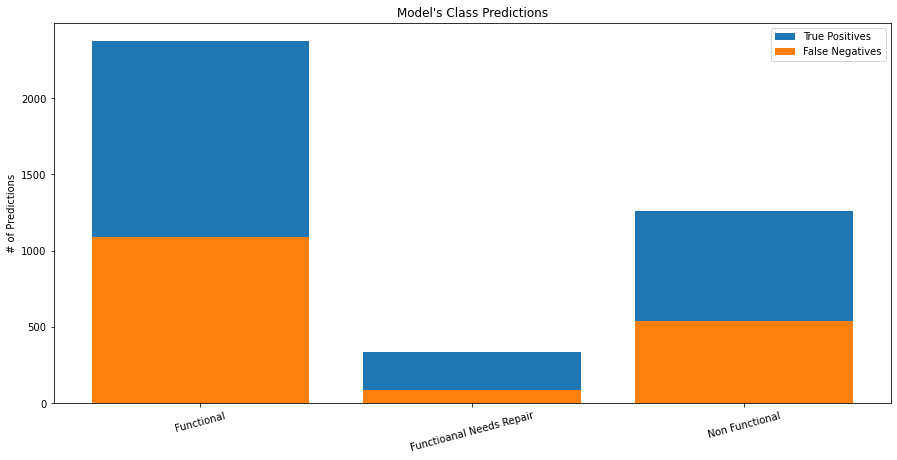

In [58]:
# Model Predictions Stack Bar Chart
labels = ["Functional", "Functioanal Needs Repair", "Non Functional"]

true_pos= [2376, 334, 1263]
false_neg = [1087, 88, 540]


fig, ax = plt.subplots(figsize=(15, 7))

ax.bar(labels, true_pos, label='True Positives')
ax.bar(labels, false_neg, label='False Negatives')

ax.set_ylabel('# of Predictions')
#ax.set_xlabel('Pedicted Class')

ax.set_title("Model's Class Predictions")
ax.legend()


plt.xticks(rotation=15)
plt.show()

In [ ]:
# finding feature importances
coefs = lr_grid2.best_estimator_.named_steps['logreg'].coef_[0]
feat_imp = pd.DataFrame(zip(X_train.columns, np.transpose(lr_grid2.best_estimator_.named_steps['logreg'].coef_.tolist()[0])), columns=['features', 'coef'])

feat_imp['coef'] = feat_imp['coef'].map(abs)
feat_imp.sort_values('coef', ascending=False)

In [ ]:
# plotting feature importance

fig, ax = plt.subplots(figsize=(15, 7))
pal = ['orange', 'orange', 'orange', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 
       'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey', 'grey']

plt.xticks(rotation=45)

sns.barplot(data=feat_imp.sort_values('coef', ascending=False), x='features', y='coef',
            palette=pal, dodge=False)
ax.set_ylabel('Importance')
ax.set_xlabel('Features')
ax.set_xticklabels(['Pump Type','Quantity','Operator Grp','Water Basin','Population',
                    'Management', 'Installer', 'Permit', 'Extractn Type', 'Region',
                    'Source', 'Operator Loc', 'H2O Qual', 'Elevation','Head Pressure',
                    'Funder', 'Const Year', 'Payment'])
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})